In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

Rows in merged training set: 590540
Columns in merged training set: 434


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Missing percentages per column:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_03            88.768923
id_04            88.768923
D6               87.606767
id_33            87.589494
id_10            87.312290
id_09            87.312290
D9               87.312290
D8               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V142             86.123717
V158             86.123717
V140             86.123717
V162             86.123717
V141             86.123717
V161             86.123717
V157             86.123717
V146             86.123717
V156             86.123

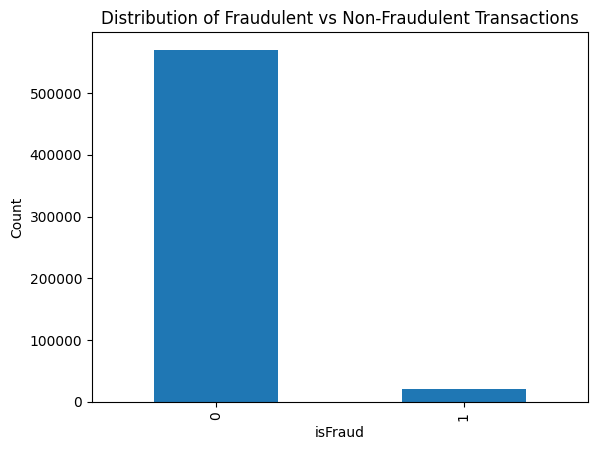

In [4]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [5]:
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [6]:
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


              m_flag_dist2   isFraud
m_flag_dist2      1.000000 -0.091096
isFraud          -0.091096  1.000000
           m_flag_D7   isFraud
m_flag_D7   1.000000 -0.164478
isFraud    -0.164478  1.000000
              m_flag_id_07   isFraud
m_flag_id_07      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_08   isFraud
m_flag_id_08      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_18   isFraud
m_flag_id_18      1.000000 -0.074815
isFraud          -0.074815  1.000000
              m_flag_id_21  isFraud
m_flag_id_21       1.00000 -0.02431
isFraud           -0.02431  1.00000
              m_flag_id_22   isFraud
m_flag_id_22      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_23   isFraud
m_flag_id_23      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_24   isFraud
m_flag_id_24      1.000000 -0.024345
isFraud          -0.024345  1.000000
              m_flag_i

In [7]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

ProductCD 5 {'H', 'W', 'S', 'C', 'R'}
card4 5 {'american express', 'visa', 'mastercard', nan, 'discover'}
card6 5 {'debit', 'credit', 'charge card', nan, 'debit or credit'}
P_emaildomain 60 {'cableone.net', 'live.fr', 'servicios-ta.com', 'yahoo.es', 'bellsouth.net', 'hotmail.fr', 'twc.com', 'yahoo.fr', 'aim.com', 'rocketmail.com', 'web.de', 'cfl.rr.com', 'gmail.com', nan, 'gmx.de', 'netzero.com', 'embarqmail.com', 'q.com', 'mac.com', 'hotmail.de', 'charter.net', 'icloud.com', 'frontiernet.net', 'yahoo.co.jp', 'live.com.mx', 'sc.rr.com', 'gmail', 'netzero.net', 'prodigy.net.mx', 'att.net', 'sbcglobal.net', 'cox.net', 'live.com', 'yahoo.de', 'outlook.com', 'windstream.net', 'ptd.net', 'yahoo.co.uk', 'ymail.com', 'frontier.com', 'earthlink.net', 'hotmail.es', 'hotmail.com', 'hotmail.co.uk', 'protonmail.com', 'mail.com', 'yahoo.com', 'juno.com', 'verizon.net', 'yahoo.com.mx', 'roadrunner.com', 'aol.com', 'msn.com', 'comcast.net', 'centurylink.net', 'optonline.net', 'me.com', 'outlook.es', 

### Find truly categorical values

In [9]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if unique_vals < unique_threshold and col != "isFraud":
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

Candidate categorical features (numeric columns with few unique values):
V1: 2 unique values
V2: 9 unique values
V3: 10 unique values
V4: 7 unique values
V5: 7 unique values
V6: 10 unique values
V7: 10 unique values
V8: 9 unique values
V9: 9 unique values
V10: 5 unique values
V11: 6 unique values
V12: 4 unique values
V13: 7 unique values
V14: 2 unique values
V15: 8 unique values
V16: 15 unique values
V17: 16 unique values
V18: 16 unique values
V19: 8 unique values
V20: 15 unique values
V21: 6 unique values
V22: 9 unique values
V23: 14 unique values
V24: 14 unique values
V25: 7 unique values
V26: 13 unique values
V27: 4 unique values
V28: 4 unique values
V29: 6 unique values
V30: 8 unique values
V31: 8 unique values
V32: 15 unique values
V33: 7 unique values
V34: 13 unique values
V35: 4 unique values
V36: 6 unique values
V39: 16 unique values
V40: 18 unique values
V41: 2 unique values
V42: 9 unique values
V43: 9 unique values
V46: 7 unique values
V47: 9 unique values
V48: 6 unique value

### Imputing nulls

In [33]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys())))
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using median strategy; add indicator if desired
num_imputer = SimpleImputer(strategy='median', add_indicator=False)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

Total missing values after imputation: 0


### Data encoding

In [34]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

### At first, let's find lox/high cardinality features

In [24]:
# Calculate cardinality for all features in X (all columns excluding the target)
cardinality = X.apply(lambda col: col.nunique())
cardinality = cardinality.sort_values(ascending=False)
print("Feature Cardinality:")
print(cardinality)

# Set a threshold to separate high vs low cardinality features (adjust as needed)
threshold = 30
high_card_cols = cardinality[cardinality > threshold].index.tolist()
low_card_cols = cardinality[cardinality <= threshold].index.tolist()

print("\nHigh Cardinality Features (unique count > {}):".format(threshold))
print(high_card_cols)
print("\nLow Cardinality Features (unique count <= {}):".format(threshold))
print(low_card_cols)

Feature Cardinality:
TransactionDT     573349
id_02             115656
V307               37367
V127               24414
V308               23064
TransactionAmt     20902
V310               19136
V306               16210
V317               15184
V203               14951
V128               14507
card1              13553
V264               13358
V204               12858
D8                 12353
V130               12332
V318               12309
V265               11757
V314               11377
V202               10970
V263               10422
V126               10299
V133                9949
V316                9814
V160                9621
V212                8868
V213                8317
V274                8315
V134                8178
V312                8068
V275                7776
V211                7624
V273                7177
V315                6973
V159                6663
V132                6560
V320                6439
V321                5560
V313                5529
V136

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
encoder_high = ce.WOEEncoder(cols=high_card_cols)
X_train_high = encoder_high.fit_transform(X_train[high_card_cols], y_train)
X_test_high = encoder_high.transform(X_test[high_card_cols])

In [ ]:
# --- Combine the processed features ---
X_train_encoded = np.hstack([X_train_high.values, X_train_rest])
X_test_encoded = np.hstack([X_test_high.values, X_test_rest])

print("Encoded training set shape:", X_train_encoded.shape)
print("Encoded test set shape:", X_test_encoded.shape)

In [11]:
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [12]:
for col in train.columns:
    if train[col].isna().sum() > 0:
        print(col, end=" ")

card2 card3 card5 addr1 addr2 dist1 dist2 D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 D11 D12 D13 D14 D15 V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 V29 V30 V31 V32 V33 V34 V35 V36 V37 V38 V39 V40 V41 V42 V43 V44 V45 V46 V47 V48 V49 V50 V51 V52 V53 V54 V55 V56 V57 V58 V59 V60 V61 V62 V63 V64 V65 V66 V67 V68 V69 V70 V71 V72 V73 V74 V75 V76 V77 V78 V79 V80 V81 V82 V83 V84 V85 V86 V87 V88 V89 V90 V91 V92 V93 V94 V95 V96 V97 V98 V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126 V127 V128 V129 V130 V131 V132 V133 V134 V135 V136 V137 V138 V139 V140 V141 V142 V143 V144 V145 V146 V147 V148 V149 V150 V151 V152 V153 V154 V155 V156 V157 V158 V159 V160 V161 V162 V163 V164 V165 V166 V167 V168 V169 V170 V171 V172 V173 V174 V175 V176 V177 V178 V179 V180 V181 V182 V183 V184 V185 V186 V187 V188 V189 V190 V191 V192 V193 V194 V195 V196 V197 V198 V199 V200 V201 V202 V203 

In [13]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31_samsung browser 5.4,id_31_samsung browser 6.2,id_31_samsung browser 6.4,id_31_samsung browser 7.0,id_31_samsung browser generic,id_31_seamonkey,id_31_silk,id_31_waterfox,Screen_Width,Screen_Height
0,2987000,0,86400,68.5,4,13926,NaN,150.0,2,142.0,...,False,False,False,False,False,False,False,False,NaN,NaN
1,2987001,0,86401,29.0,4,2755,404.0,150.0,3,102.0,...,False,False,False,False,False,False,False,False,NaN,NaN
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,False,False,False,False,False,False,False,False,NaN,NaN
3,2987003,0,86499,50.0,4,18132,567.0,150.0,3,117.0,...,False,False,False,False,False,False,False,False,NaN,NaN
4,2987004,0,86506,50.0,1,4497,514.0,150.0,3,102.0,...,False,True,False,False,False,False,False,False,2220.0,1080.0


In [14]:
train = train.fillna(0) # fill in nulls with zeroes

In [ ]:
# Drop columns that might be mostly NaN
drop_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
train.drop(columns=drop_cols, inplace=True)

# Fill remaining NaNs (simplistic approach)
train.fillna(-999, inplace=True)

# Label-encode some categorical features (example)
cat_cols = ["ProductCD", "card4", "DeviceType"]  # minimal example
for c in cat_cols:
    if c in train.columns:
        train[c] = train[c].astype(str)
        train[c] = LabelEncoder().fit_transform(train[c])

In [15]:
# Target is "isFraud"
X = train.drop(["isFraud", "TransactionID"], axis=1, errors="ignore")
y = train["isFraud"]

# Simple split (no cross-validation for brevity)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Data normalization

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def run_genetic_algorithm(X_data, y_data):
    """
    Placeholder for GA. Return a subset of feature indices.
    """
    # TODO: Implement population, crossover, mutation, selection, etc.
    # For demonstration, return all features:
    return np.arange(X_data.shape[1])

best_features = run_genetic_algorithm(X_train, y_train)
X_train_ga = X_train.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]

In [ ]:
model = SVC(kernel="rbf")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Baseline model Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
def run_pso_for_hyperparams(X_data, y_data, model_class):
    """
    Placeholder for PSO. Return best hyperparams found.
    """
    # TODO: Swarm initialization, velocity updates, fitness evaluation, etc.
    return {"C": 1.0, "kernel": "rbf"}  # example

best_params = run_pso_for_hyperparams(X_train_ga, y_train, SVC)
model_pso = SVC(**best_params)
model_pso.fit(X_train_ga, y_train)
y_pred_pso = model_pso.predict(X_test_ga)
print("PSO-tuned model Accuracy:", accuracy_score(y_test, y_pred_pso))

In [ ]:
def run_aco_classification(X_data, y_data):
    """
    Placeholder for ACO. Return final classification model or rules.
    """
    # TODO: ACO logic with ants’ path optimization, pheromone updates, etc.
    # Here we simply return the same baseline model for demonstration:
    return SVC(kernel="rbf")

aco_model = run_aco_classification(X_train_ga, y_train)
aco_model.fit(X_train_ga, y_train)
y_pred_aco = aco_model.predict(X_test_ga)
print("ACO-based model Accuracy:", accuracy_score(y_test, y_pred_aco))